In [1]:
import pandas as pd
import numpy as np
from plotnine import *

In [ ]:
# Import Local Data
local = pd.read_csv('../Data/NTD-Funding-Sources-Local.csv')

# Standardize column names
local.columns = local.columns.str.strip().str.lower().str.replace(' ', '_')

local['total_funding'] = local['total']
# local.to_csv('Cleaned-NTD-Funding-Local.csv', index=False, na_rep='NA')

In [5]:
local_clean = pd.read_csv('../Data/Cleaned-NTD-Funding-Local.csv')

In [6]:
print(local_clean.columns)

Index(['agency', 'city', 'state', 'ntd_id', 'organization_type',
       'reporter_type', 'report_year', 'uace_code', 'uza_name',
       'primary_uza_population', 'voms', 'general_fund', 'income_tax',
       'sales_tax', 'property_tax', 'fuel_tax', 'other_tax', 'tolls',
       'other_funds', 'reduced_funds', 'total', 'total_funding'],
      dtype='object')


In [5]:
print(local_clean.describe())

             ntd_id  report_year     uace_code  primary_uza_population  \
count     80.000000         80.0     42.000000            4.200000e+01   
mean   20578.300000       2023.0  57433.809524            9.926447e+06   
std      565.262108          0.0  20747.081630            9.628572e+06   
min    20002.000000       2023.0     36.000000            5.183200e+04   
25%    20118.250000       2023.0  58478.500000            3.147660e+05   
50%    20222.000000       2023.0  63217.000000            1.142586e+07   
75%    20957.250000       2023.0  63217.000000            1.942645e+07   
max    22930.000000       2023.0  92674.000000            1.942645e+07   

               voms  general_fund    income_tax     sales_tax  property_tax  \
count     80.000000  8.000000e+01  8.000000e+01  8.000000e+01  8.000000e+01   
mean     208.162500  3.278701e+07  2.569571e+05  4.309474e+05  5.865306e+06   
std     1135.549535  1.888651e+08  2.298294e+06  3.109505e+06  4.349748e+07   
min        1.0000

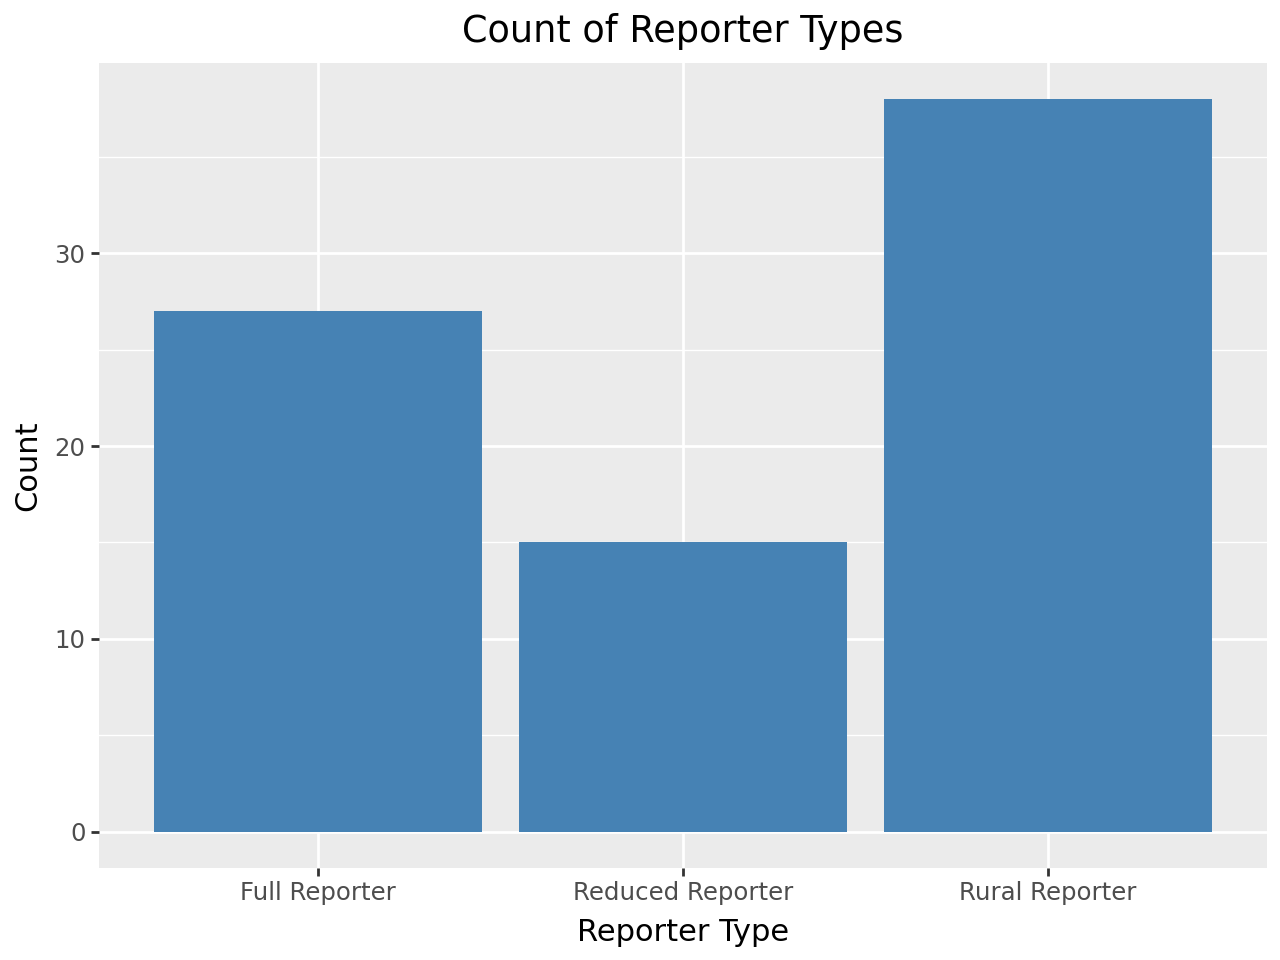

In [13]:
(ggplot(local_clean, aes(x='reporter_type')) +
    geom_bar(fill="steelblue") +
    labs( title="Count of Reporter Types",
     x="Reporter Type",
     y="Count")
)

c:\Users\bri_r\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 38 rows containing non-finite values.


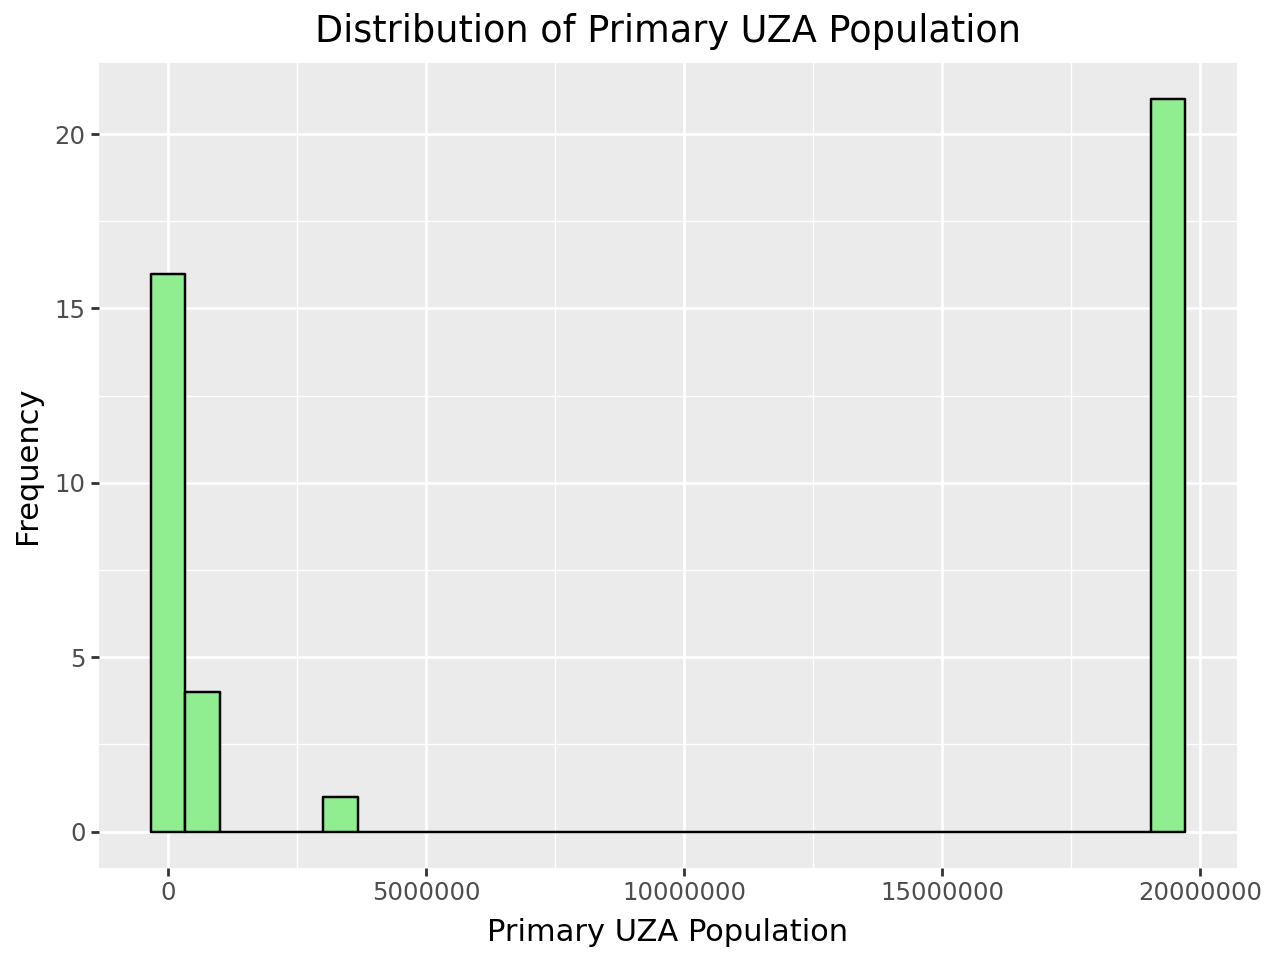

In [14]:
(ggplot(local_clean, aes(x='primary_uza_population')) +
    geom_histogram(bins=30, fill="lightgreen", color="black") +
    labs(title="Distribution of Primary UZA Population",
     x="Primary UZA Population",
     y="Frequency")
)


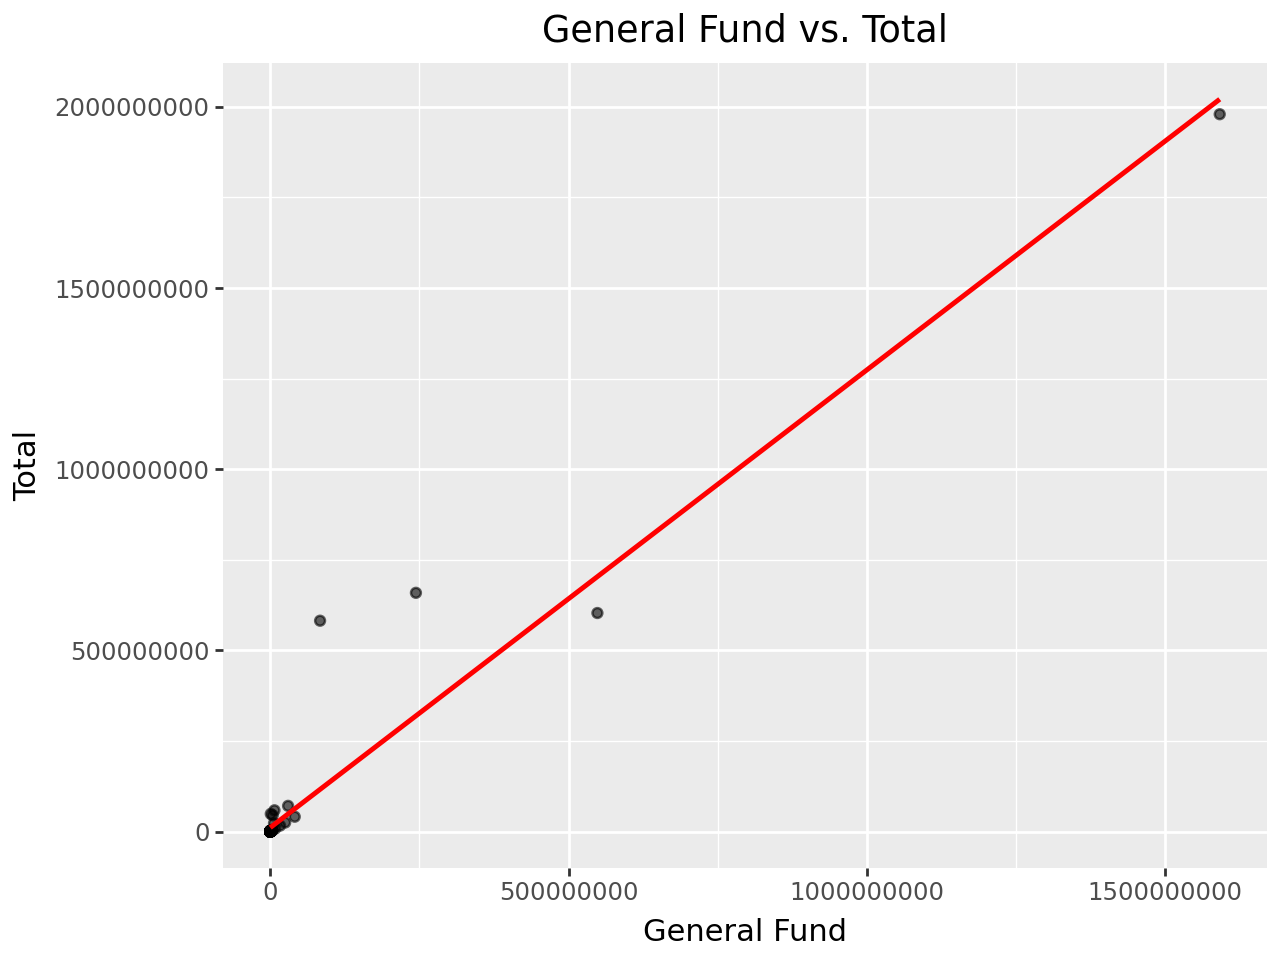

In [15]:
(ggplot(local_clean, aes(x='general_fund', y='total')) +
    geom_point(alpha=0.6) +
    geom_smooth(method='lm', color='red', se=False) +
    labs( title="General Fund vs. Total",
     x="General Fund",
     y="Total")
)

c:\Users\bri_r\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


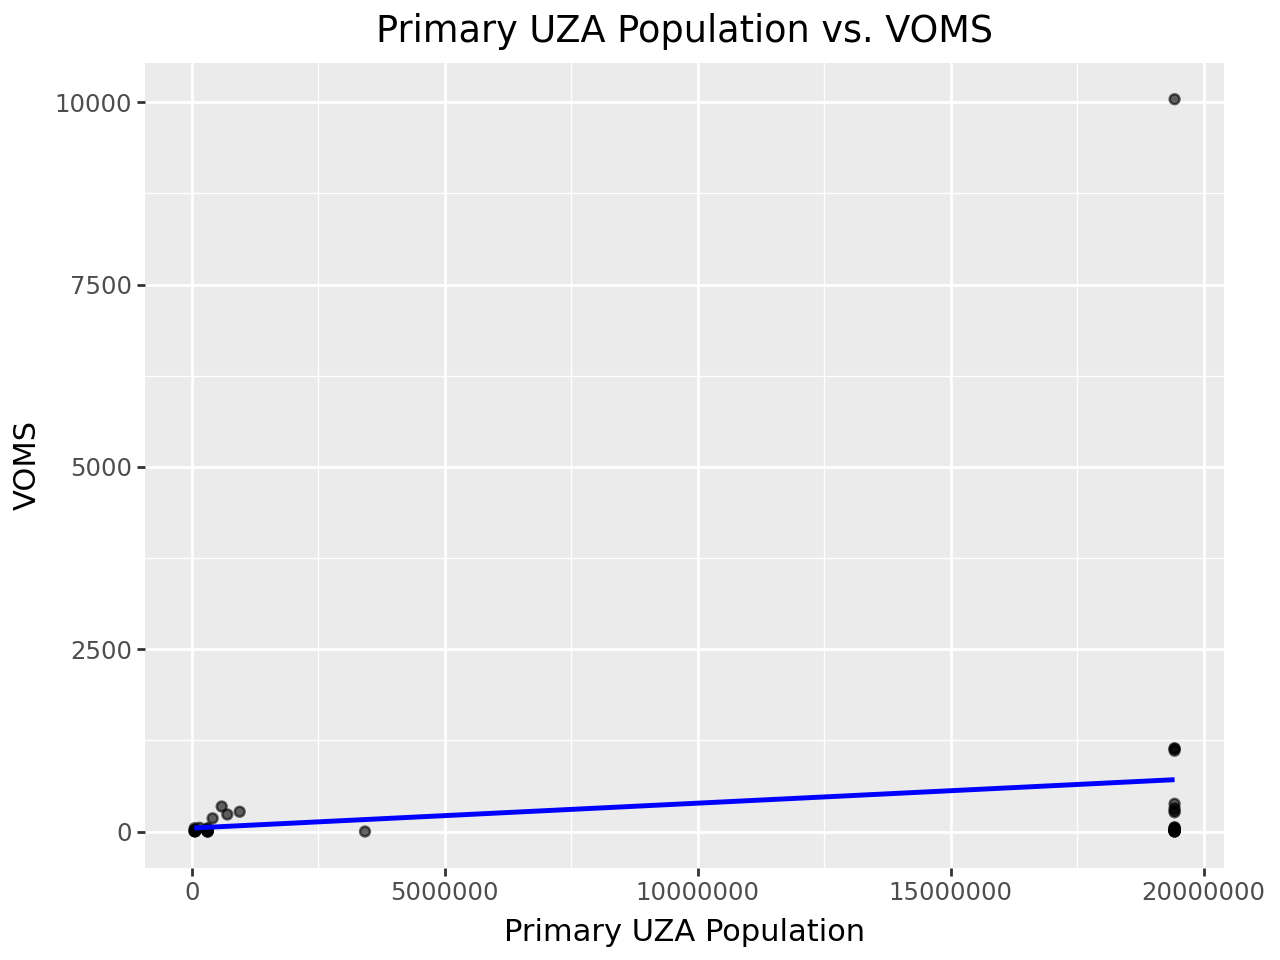

In [19]:
(ggplot(local_clean, aes(x='primary_uza_population', y='voms')) +
    geom_point(alpha=0.6) +
    geom_smooth(method='lm', color='blue', se=False) +
    labs(title="Primary UZA Population vs. VOMS",
     x="Primary UZA Population",
     y="VOMS")
)
